### Goal of this notebook is to understand variational auto encoders but we shall take a long and exhausting off shoot to reach `VAEs`. PERT problem below is a direct copy of the [notebook](https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-importance_sampling/DAG_example.ipynb). I will add some motivation and other examples as i go on...
#### Some good links
* [Source1](https://bjlkeng.github.io/posts/importance-sampling-and-estimating-marginal-likelihood-in-variational-autoencoders/)
* [Source2](https://www.youtube.com/watch?v=S3LAOZxGcnk&list=PLD0F06AA0D2E8FFBA&index=131)
* [Source3](https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import fivecentplots as fcp
from IPython.display import display, HTML
import warnings
sns.set(style="darkgrid")
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Could not import win32clipboard.  Make sure pywin32 is installed to use the paste from clipboard option.


In [108]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Why do we need monte carlo methods?

* In many applications we have to calculate the value of $E(h(\textbf{X}))$ where $\textbf{X} \sim f$. 

$E(h(\textbf{X})) = \int h(\textbf{x})f(\textbf{x})d{\textbf{x}} = \mu \tag{1}$

We can approximate $1$ using 
$\hat{\mu_{MC}} = \frac{1}{n}\sum_{1}^{n}h(\textbf{X}_i) \tag{2}$ where $\textbf{X}_i,..,\textbf{X}_n$ are an i.i.d random samples obtained from $f$. 

* From Page 180 of Given and Hoeting under section $6.4.1$.
* Suppose we wish to estimate the probability that a die roll will yield a one. If we roll the die $n$ times, we would expect to see about $n/6$ ones, and our point estimate of the true probability would be the proportion of the ones in the sample. The variance of this estimator is $5/36n$ and mean is $1/6$ if the die is fair. To achieve an estimate with a coefficient of variation of, say, $5\%$, one should expect to have to roll the die $2000$ times!! 
* Let's see how we came to this conclusion:
* Let $X_i \sim Ber(\frac{1}{6})$.
* Our point estimator is the proportion of ones in the sample
$Y = \frac{X_1 + X_2 + X_2,...,X_n}{n} \tag{1}$
* $X_i = 1$ if a one shows up and $X_i = 0$ otherwise.
 $E(Y) = \frac{1}{n}\sum_{i}^{n}E(X_i)=\frac{1}{n}\times n\times \frac{1}{6} = \frac{1}{6} \tag{2}$ 
 
 $Var(Y) = \frac{1}{n^2}\sum_{1}^{n}Var(X_i) = \frac{npq}{n^2} = \frac{pq}{n} = \frac{5}{36n} \tag{3} $
 
* Since $X_i \sim Ber(p)$ so, $Var(X_i) = pq $ and $E(X_i) = p$.
* Coefficient of variation is $\frac{\sigma}{\mu}$ which is $\frac{\sqrt(Var(Y)}{E(Y)}$ which can be written as
$\frac{\sqrt(\frac{5}{36n}}{\frac{1}{6}} \tag{4}$
* If we subsitute $n$ with $2000$ in above equation then we get $5\%$ c.v.
* Is there a way to roll the die significantly less number of times and still achieve a c.v of $5\%$? Yes, there is but let's simulate and verify our conclusions



In [109]:
import random
def rollDie(number):
    '''
    Source: https://stackoverflow.com/questions/19188546/python-dice-rolling-simulation
    function not modified
    '''
    rolls = [0] * 6
    for i in range(0, number):
        roll=int(random.randint(1,6))
        rolls[roll - 1] += 1
    return rolls
data = []
nSims = [40*i for i in range(1,101)]
for sim in nSims:
    rolls = rollDie(sim)
    data.append((sim,float(rolls[0])/(sum(rolls))))

data_simple_mc = pd.DataFrame(data, columns=['nSims', 'pointEstimate'])   

In [118]:
print('Variance of point estimate:{}'.format(data_simple_mc.pointEstimate.var()))
print('Mean of point estimate:{}'.format(data_simple_mc.pointEstimate.mean()))

Variance of point estimate:0.00017874425451682867
Mean of point estimate:0.16482878993838365


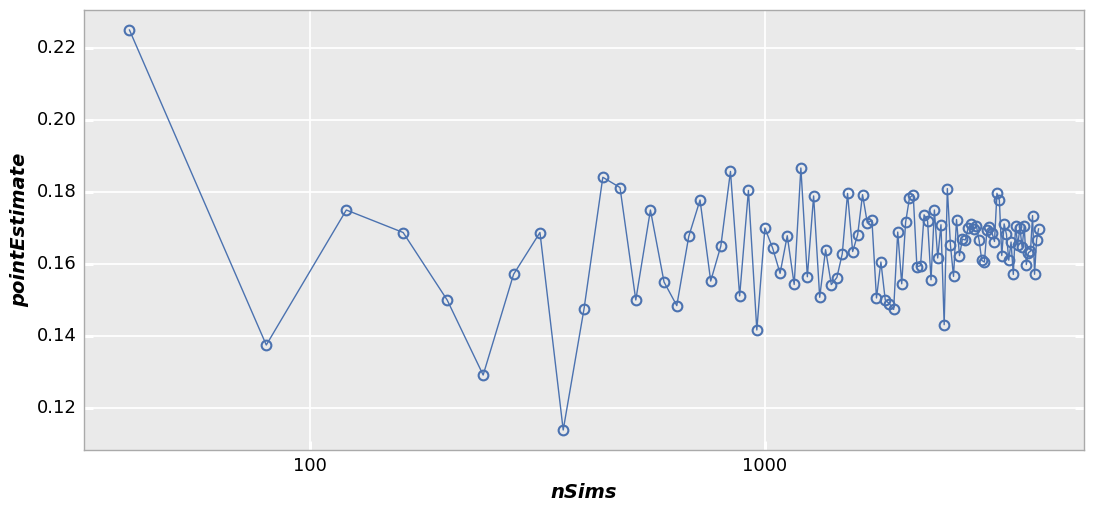

In [113]:
fcp.plot(data_simple_mc, x='nSims',y='pointEstimate',lines = True, markers = True,ax_size=(1000,440),ax_scale='logx')

* You can see that our point estimate, $E(y) \approx \frac{1}{6}$ but that required at least $10^4$ rollings.  

* Earlier, we asked ourselves a question, can we roll the die significantly less number of times and still get a decent approximation for our point estimate?
* Consider replacing the faces $2$ and $3$ with $1$ on the die, now, the probability of rolling a $1$ is $0.5$ but we are no longer sampling from our original distribution(unbiased die), instead we're sampling from a biased die, we have to correct for that and it can be done by scaling our outcomes with $\frac{1}{3}$ if we roll a $1$. 
* Our point estimate is 
$ Y = \frac{1}{3} \times \frac{\textbf{X}}{n} \tag{1} $

* $\textbf{X} \sim Bin(\frac{1}{2})$ and $E(Y)$ is:
$ E(Y) = \frac{1}{3} \times \frac{E(\textbf{X})}{n} = \frac{1}{3} \times \frac{np}{n} = \frac{1}{6} \\ \text{as} \ E(\textbf{X}) = np \tag{2}$

* $Var(Y)$ is:
$ Var(Y) = \frac{1}{n^2} \times \frac{1}{9} Var(\textbf{X}) = \frac{1}{n^2} \times \frac{1}{9} \times npq = \frac{pq}{9n} = \frac{1}{36n} \\ \text{as} \ Var(\textbf{X}) = npq \tag{3}$

* To achieve a coefficient of variation of $5\%$, we need only $400$ rolls! 
* Another way to look at the above problem is 
$Y = \frac{X_1/3 + X_2/3 + X_3/3,...,X_n/3}{n} \tag{4}$
* $X_i = 1$ if a one shows up and $X_i = 0$ otherwise. $ X_i \sim Bin(\frac{1}{2})$. We scaled our random variable with $1/3$ because of above reasons.
$E(Y) = \frac{1}{3n} \times \sum_{i}^{n}E(X_i) = \frac{1}{3n} \times n \times E(X_i) \tag{5} = \frac{1}{6} \\ \text{as} 
\ E(X_i) = \frac{1}{2}$

$Var(Y) = \frac{1}{n^2} \times \frac{n}{9} \times Var(X_i) = \frac{pq}{9n} = \frac{1}{36n} \tag{6} \\ \text{as} \ Var(X_i) = pq = \frac{1}{4} $

In [114]:
def biasedRoll(nTimes,sides, bias_list):
    '''
    Source: https://stackoverflow.com/questions/479236/how-do-i-simulate-biased-die-in-python
    function slightly modified
    '''
    rolls = [0]*sides
    for time in range(nTimes):
        assert len(bias_list) == sides
        number = random.uniform(0, sum(bias_list))
        current = 0
        roll = None
        for i, bias in list(enumerate(bias_list)):
            current += bias
            if number <= current:
                roll = i + 1
                rolls[roll-1]+=1
                break ## break the loop once you find the roll
    return rolls

data = []
nSims = [40*i for i in range(1,101)]
for sim in nSims:
    rolls = biasedRoll(sim,6, (1/2, 0.0, 0.0, 1/6, 1/6, 1/6))
    data.append((sim,float(rolls[0])/(3*sum(rolls))))

data_imp_sampl = pd.DataFrame(data, columns=['nSims', 'pointEstimate'])   

In [119]:
print('Variance of point estimate:{}'.format(data_imp_sampl.pointEstimate.var()))
print('Mean of point estimate:{}'.format(data_imp_sampl.pointEstimate.mean()))

Variance of point estimate:3.996690185648033e-05
Mean of point estimate:0.16690045124694422


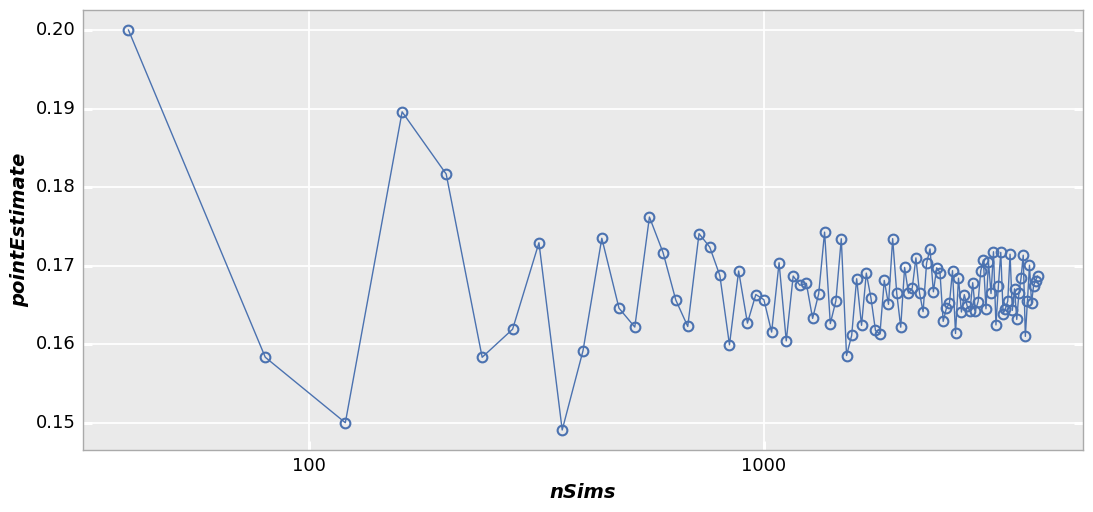

In [117]:
fcp.plot(data_imp_sampl, x='nSims',y='pointEstimate',lines = True, markers = True,ax_size=(1000,440),ax_scale='logx')

* You can see that for the same number of iterations, important sample based monte carlo yielded a variance that is an order less than a simple monte carlo. This is why importance sampling is also used in variance reduction techniques. Rolling a biased die in the above can be thought of as _importance sampling distribution_(_envelope_). Scaling factor $\frac{1}{3}$ can be thought of as _importance weightining_. 

## Why do we need sampling methods?
* Watch [Nando De Freitas](https://www.youtube.com/watch?v=TNZk8lo4e-Q) lectures. (1min-9min)

* Suppose in a neural network with [Softmax activation](https://en.wikipedia.org/wiki/Softmax_function), the outputs are likelihoods.  
* Suppose $p(\textbf{y}|\textbf{X}; \theta)$ is a likelihood, $p(\theta)$ is a prior and $p(\theta|\textbf{X};\textbf{y})$ a posterior. Then

 $\begin{align*}
 p(\theta|\textbf{X};\textbf{y}) = \frac{p(\textbf{y}|\textbf{X}; \theta)p(\theta)}{\int_{\theta}p(\textbf{y}|\textbf{X}; \theta)p(\theta)d\theta} \tag{1}
 \end{align*}$

$ \begin{align*}
Z  \triangleq  \int_{\theta}p(\textbf{y}|\textbf{X}; \theta)p(\theta)d\theta \tag{2}
\end{align*}$
Z can also thought of as a normalizing factor or as a total probability in a simple byesian problems (like in the most famous breast cancer problem)

* If you look at eq $1$ with a bayesian perspective then a lot of times the denominator is intractable or unknown hence sampling methods are a way to approximate $Z$. Sampling is to bayesian methods as optimization is to MLPs(maximum likelihood problems).

* In a frequentist (deterministic) setting, if you want to maximize the posterior in equation $1$ you will simply take a $-log$ of the posterior which then becomes

$-log(p(\theta|\textbf{X};\textbf{y}) = log(Z) - log(p(\textbf{y}|\textbf{X}; \theta)) - log(p(\theta)) \tag{3}$
* The above equation is maximized(minimized) w.r.t $\theta$ and note that $Z$ doesn't depend on $\theta$ as it is marginalized(integrated) w.r.t $\theta$. 

* $log(p(\textbf{y}|\textbf{X}; \theta))$ is the cost function and $log(p(\theta))$ is the regularization factor.

## Importance sampling when you can't sample from a distribution but can evaluate 
* You have closed form of the distributions $p$ and $q$ (i.e, along with normalization factors).

* Importance sampling is also used when we don't know how to sample from a distrubution but when we have a closed form of that distribution so that it can be evaluated at any point. Let's denote $E_{p}(f(X))$ expectation of a function $f(X)$ where $X \sim p$.
* In simple monte carlo we can evaluate it with 
$E_{p}(f(X)) = \int f(X)p(X)dx \approx \frac{1}{n}\sum_{i}^{n}f(X_{i}) \tag{4}$
* Where $X_1, X_2,...,X_n$ are $i.i.d$ from $p$. But we were told that we can't sample from $p$. So consider another p.d.f $q$ from which you can sample and $q(x)=0$ if $p(x)=0$.
$E_{p}(f(X)) = \int \underbrace{f(X)\frac{p(X)}{q(X)}}q(X)dx \tag{5}$
$w(X) = \frac{p(X)}{q(X)} \tag{6}$
$g(X) = f(X)w(X) \tag{7}$
$E_{p}(f(X)) = \int g(X)q(X)dx  \tag{8}$
* Right hand side of the above equation looks like it can be approximated with a simple monte carlo
$E_{p}(f(X)) \approx \frac{1}{n}\sum_{i}^{n}g(X_{i}) \tag{9}$
* Where $X_1, X_2,...,X_n$ are $i.i.d$ from $q$ and w(X) can be seen like a correction factor for drawing from a p.d.f other than $p$. $w(X)$ is _importance weights function_.
* Let's see if our estimate is an unbiased estimator, we take the expectation of the right side of $eq9$.

$E_{q}(\frac{1}{n}\sum_{i}^{n}f(X_i)w(X_i)) \tag{10}$ 

* $X_i$ are i.i.d from $q$

$\frac{1}{n}\sum_{i}^{n}E_q(f(X_i)w(X_i)) = \frac{1}{n}\sum_{i}^{n}\int f(X_i)w(X_i)q(X_i)dx = 
\frac{1}{n}\sum_{i}^{n}\int f(X_i)\frac{p(X_i)}{q(X_i)}q(X_i)dx = \frac{1}{n}\sum_{i}^{n}\int f(X_i)p(X_i)dx =
\frac{n}{n}E_{p}(f(X)) $

$ E_{p}(f(X)) \tag{11} $
* So the estimator is an unbiased estimator.
* Let's find the variance of the estimator
$ Var(\frac{1}{n}\sum_{i}^{n}f(X_i)\frac{p(X_i)}{q(X_i)}) = \frac{1}{n^2} \times n \times Var(f(X_i)\frac{p(X_i)}{q(X_i)})) = \frac{1}{n} \times Var(f(\textbf{X})\frac{p(\textbf{X})}{q(\textbf{X})}))  \tag{12}$
* Where $\textbf{X} \sim q $.
* In a simple monte carlo variance is 
$ Var(E_{p}(f(\textbf{X}))) = \frac{1}{n} \times Var(f(\textbf{X})) \tag{13}$ 
* Where $\textbf{X} \sim p $.
* You can make equation 12 less than equation 13 by adjusting the ratio $\frac{p(\textbf{X})}{q(\textbf{X})}$. So, _importance sampling helps not only in lowering the variance of the estimator but also helps in the cases where you can't sample from a required distribution_.

## Importance sampling without normalization constants
* You don't know normalization factors for distributions for either $p$ and $q$ or both.
* Assume $p(X) = \frac{\widetilde{p(X)}}{Z_p}$ and $q(X) = \frac{\widetilde{q(X)}}{Z_q}$. Without knowing $Z_p$ and $Z_q$ you can't do importance sampling because you can't evaluate the _importance wegiths function_ ($w(X)$). We can use rejection sampling to generate samples from $q(X)$. Mathematically $\int \widetilde{p(X)} dX = Z_p$ and  $\int \widetilde{q(X)} dX = Z_q$ what if we can't integrate and find the normalizing constants? This variation of Importance sampling will be hlepful to solve that issue.  
$E_{p}(f(X)) = \int f(x)\frac{p(x)}{q(x)}q(x)dx = \int f(x)\frac{\widetilde{p(x)}}{\widetilde{q(x)}}\frac{Z_q}{Z_p}q(x)dx \approx \frac{Z_q}{Z_p}\frac{1}{n}\sum_{1}^{n} f(X_i)\frac{\widetilde{p(X_i)}}{\widetilde{q(X_i)}} =\frac{Z_q}{Z_p}\frac{1}{n}\sum_{1}^{n} f(X_i)\widetilde{w(X_i)}  \tag{1}$
* Where X_i are $i.i.d$ from $q$ and $\widetilde{w(X_i)} = \frac{\widetilde{p(X_i)}}{\widetilde{q(X_i)}}$. We don't know how to calculate $\frac{Z_q}{Z_p}$. Because we know how to sample from $q(X)$ we can write the ratios of $Zs$ as
$\frac{Z_p}{Z_q} = \frac{1}{Z_q} \int \widetilde{p(x)}dx = \int \frac{\widetilde{p(x)}}{\widetilde{q(x)}}q(x)dx \approx \frac{1}{n}\sum_{1}^{n}\frac{\widetilde{p(X_i)}}{\widetilde{q(X_i)}} = \frac{1}{n}\sum_{1}^{n} \widetilde{w(X_i)}\tag{2}$
* Where $X_i$ are $i.i.d$ from $q(x)$. from $eq1$ and $eq2$
$E_{p}(f(X)) \approx \frac{\frac{1}{n}\sum_{1}^{n} f(X_i)\widetilde{w(X_i)}}{\frac{1}{n}\sum_{1}^{n} \widetilde{w(X_i)}} \tag{3} = \frac{1}{n}\widehat{w(X_i)}f(X_i) $
* Where $X_i$ are $i.i.d$ from $q(x)$ and $\widehat{w(X_i)} = \frac{\widetilde{w(X_i)}}{\frac{1}{n}\sum_{i}^{n}\widetilde{w(X_i)}}$, $\widetilde{w(X_i)}$ is an estimator of weights $w(X_i)$, the weights in the simple importance sampling case.

## Original PERT Problem
[Source](https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf)

In [5]:
# DAG
dag = [
     {'depends': [], 'duration': 4},
     {'depends': [0], 'duration': 4},
     {'depends': [0], 'duration': 2},
     {'depends': [1], 'duration': 5},
     {'depends': [1], 'duration': 2},
     {'depends': [2], 'duration': 3},
     {'depends': [2], 'duration': 2},
     {'depends': [2], 'duration': 3},
     {'depends': [4, 5, 6], 'duration': 2},
     {'depends': [3, 7, 8], 'duration': 2},
]

for i, task in enumerate(dag):
    print("Task {}: duration: {}, depends on {}".format(i+1, task['duration'], [x+1 for x in task['depends']]))

Task 1: duration: 4, depends on []
Task 2: duration: 4, depends on [1]
Task 3: duration: 2, depends on [1]
Task 4: duration: 5, depends on [2]
Task 5: duration: 2, depends on [2]
Task 6: duration: 3, depends on [3]
Task 7: duration: 2, depends on [3]
Task 8: duration: 3, depends on [3]
Task 9: duration: 2, depends on [5, 6, 7]
Task 10: duration: 2, depends on [4, 8, 9]


## Time taken as a deterministic value given in the table

In [6]:
def simulate(dag):
    samples = []
    for task in dag:
        samples.append(task['duration'])
    
    times = np.zeros(len(dag))
    for i, task in enumerate(dag):
        if task['depends']:
            times[i] = np.max(times[task['depends']] + samples[i])
        else:
            times[i] = samples[i]
            
    df = pd.DataFrame(times).transpose()
    df.columns = ['task_' + str(x+1) for x in df.columns]
    return df
        
simulate(dag)

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,4.0,8.0,6.0,13.0,10.0,9.0,8.0,9.0,12.0,15.0


## Time taken as a exponential random variable 
* with $\lambda = $given deterministic time 

In [7]:
def simulate(n, dag):
    samples = []
    for task in dag:
        samples.append(np.around(np.random.exponential(task['duration'],n),decimals=3))
    
    times = np.zeros((len(dag),n))
    for i, task in enumerate(dag):
        if task['depends']:
            times[i,:] = np.max(times[task['depends'],:] + samples[i],axis=0)
        else:
            times[i,:] = samples[i]
            
    df = pd.DataFrame(times).transpose()
    df.columns = ['task_' + str(x+1) for x in df.columns]
    return df
        
simulate(5,dag)

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,2.529,6.896,2.954,7.689,8.494,10.231,6.518,5.844,13.324,20.467
1,2.535,7.543,5.282,11.929,9.821,7.471,6.269,7.292,10.334,13.928
2,1.021,3.124,7.173,21.601,7.147,8.236,7.762,7.646,9.818,24.377
3,8.323,13.178,9.125,24.484,17.747,12.476,10.043,14.239,20.184,25.708
4,4.000,18.602,5.132,22.658,20.608,6.916,7.213,8.556,27.424,27.899


## Probability distribution of the completion time

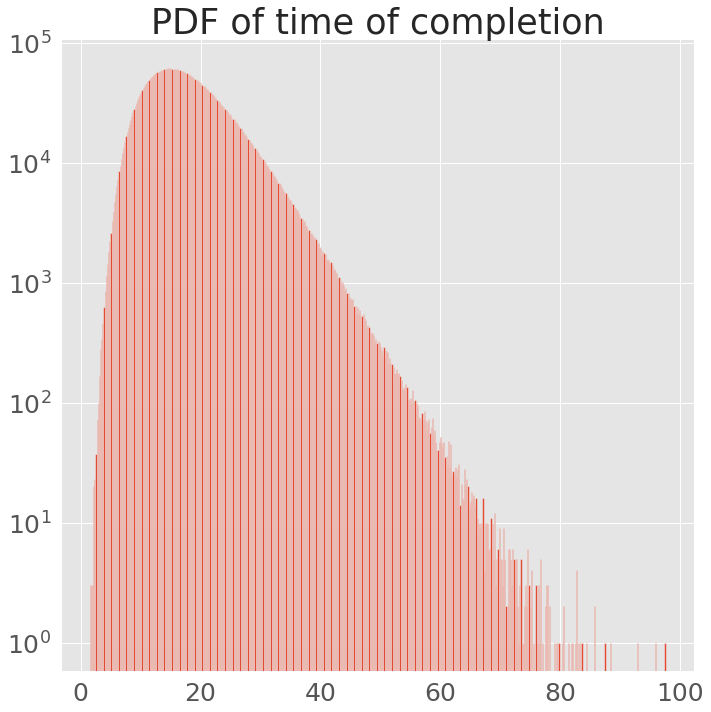

In [8]:
df = simulate(5000000, dag)
plt.style.use('ggplot')
params = {'axes.titlesize':'35',
          'xtick.labelsize':'25',
          'ytick.labelsize':'25'}
matplotlib.rcParams.update(params)
df.task_10.hist(figsize = (10,10),bins=500)
#req_data.hist()
plt.title('PDF of time of completion')
plt.yscale('log')
plt.tight_layout()
plt.show()

## Number of times we might cross the 25 day threshold

,N,count,ratio
0,1000,161,0.161000
1,10000,1571,0.157100
2,50000,7980,0.159600
3,100000,15649,0.156490
4,500000,78950,0.157900
5,1000000,157859,0.157859
6,5000000,787240,0.157448


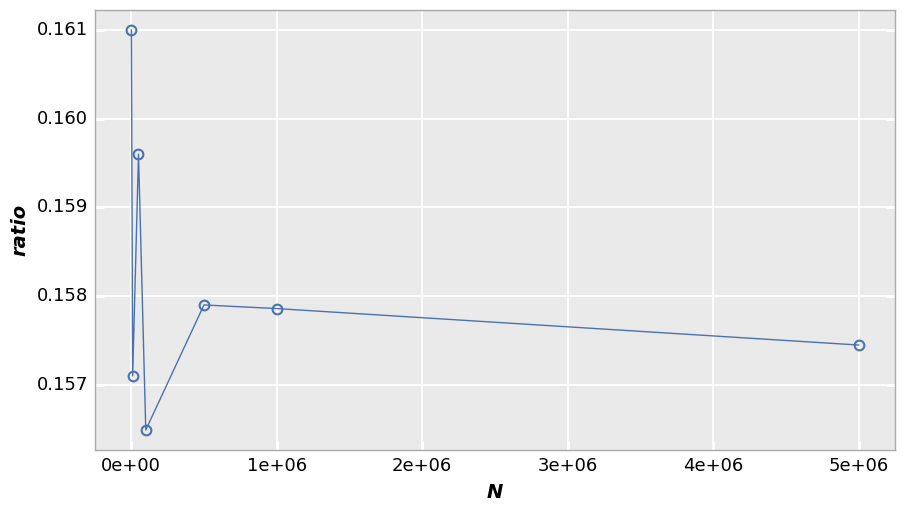

In [9]:
trials = []
threshold = 25
for N in [1000, 10000, 50000, 100000, 500000, 1000000, 5000000]:
    df = simulate(N, dag)
    count = len(df[df.task_10 > threshold])
    trials.append({'N': N, 'count': count, 'ratio': count / len(df)})
                  
trials = pd.DataFrame(trials)
display(trials)
#sns.lineplot(x='N', y='ratio', data=trials, markers=True, marker='o')
plt.style.use('ggplot')
fcp.plot(trials, x='N',y='ratio',lines = True, markers = True,ax_size=(800,440))

## Using importance sampling to reduce the number of experiemnts

* Estimate, P(Time taken) >= threshold is given by 
$\hat{\mu} = \frac{1}{n} \sum_{i=1}^n \mathbb{1}(D_{i} \geq 70) \prod_{j=1}^{10}\frac{\frac{1}{\theta_j}exp(\frac{-T_{ij}}{\theta_j})}{\frac{1}{\lambda_j}exp(\frac{-T_{ij}}{\lambda_j})} \tag{1}$

* Consider
$\hat{w} = \prod_{j=1}^{10} \frac{\frac{1}{\theta_j}exp(\frac{-T_{ij}}{\theta_j})}{\frac{1}{\lambda_j}exp(\frac{-T_{ij}}{\lambda_j})} \tag{2}$

* Taken the log
$\log(\hat{w}) = \sum_{j=1}^{10}((-\log(\theta_j) - \frac{T_{ij}}{\theta_j}) - (-\log(\lambda_j) - \frac{T_{ij}}{\lambda_j})) \tag{3}$
 
 * $\theta_{j}$ are the original times given in the table and $\lambda_{j}$ are the guessed means of the proposal distribution (in this came the variable, `importance_parameters`). $T_{j}$ are the samples generated from an exponential distribution with mean $\lambda_{j}$. $T_j \sim Exp(\lambda_j)$. 

In [10]:
def simulate_importance(n, dag, importance_parameters=None):
    ''' Compute E(T_10 >= 70) = 1/n \sum I(T_10 > 70) \pi_k likelihood_ratio_k '''
    if importance_parameters is None:
        importance_parameters = [1.] * (len(dag))
    assert len(dag) == len(importance_parameters)
   
    # Sample from the importance distribution to get all our task times
    q_samples = []
    durations = []
    for i, task in enumerate(dag):
        durations.append(task['duration'])
        q_sample = np.random.exponential(importance_parameters[i], n)
        q_samples.append(q_sample)
            
    # Compute the likelihood ratios in log space [exp(-T/\theta) /\theta] / [exp(-T/\lambda) / \lambda]
    stacked_q_samples = np.stack(q_samples, axis=1)
    log_durations = np.log(durations)
    log_importance_parameters = np.log(importance_parameters)
    likelihoods = np.sum((-log_durations - stacked_q_samples / durations) - 
                         (-log_importance_parameters - stacked_q_samples / importance_parameters),
                         axis=1)
                  
    # Compute final outcome variable
    times = np.zeros((len(dag), n))
    for i, task in enumerate(dag):
        if task['depends']:
            times[i, :] = np.max(times[task['depends'], :] + q_samples[i], axis=0)
        else:
            times[i, :] = q_samples[i]
                
    outcome = np.where(times[-1, :] >= 70, 1., 0.) * np.exp(likelihoods)
    return np.mean(outcome)

#params = [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]
params = [16, 16, 2, 20, 2, 3, 2, 3, 2, 16]
simulate_importance(10000, dag, params)

2.9349357234004215e-05

In [11]:
distributions = [
    ('original', [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]), # original
    ('4x_all', [4 * x for x in [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]]), # quadrupling
    ('2x_critical', [8, 8, 2, 10, 2, 3, 2, 3, 2, 4]), # 2x Multiplicative change in bottleneck tasks 1, 2, 4, 10
    ('3x_critical', [12, 12, 2, 15, 2, 3, 2, 3, 2, 12]), # 3x Multiplicative change in bottleneck tasks 1, 2, 4, 10
    ('4x_critical', [16, 16, 2, 20, 2, 3, 2, 3, 2, 16]), # 4x Multiplicative change in bottleneck tasks 1, 2, 4, 10
]

data = []
for name, importance_params in distributions:
    for N in [1000, 10000, 50000, 100000, 500000, 1000000]:
        mean = simulate_importance(100000, dag, importance_params)
        data.append((name, N, mean))
df_importance = pd.DataFrame(data, columns=['experiment', 'sample_size', 'mean'])        
display(df_importance.head(10))

,experiment,sample_size,mean
0,original,1000,0.000070
1,original,10000,0.000030
2,original,50000,0.000030
3,original,100000,0.000060
4,original,500000,0.000020
5,original,1000000,0.000050
6,4x_all,1000,0.000028
7,4x_all,10000,0.000023
8,4x_all,50000,0.000049
9,4x_all,100000,0.000046


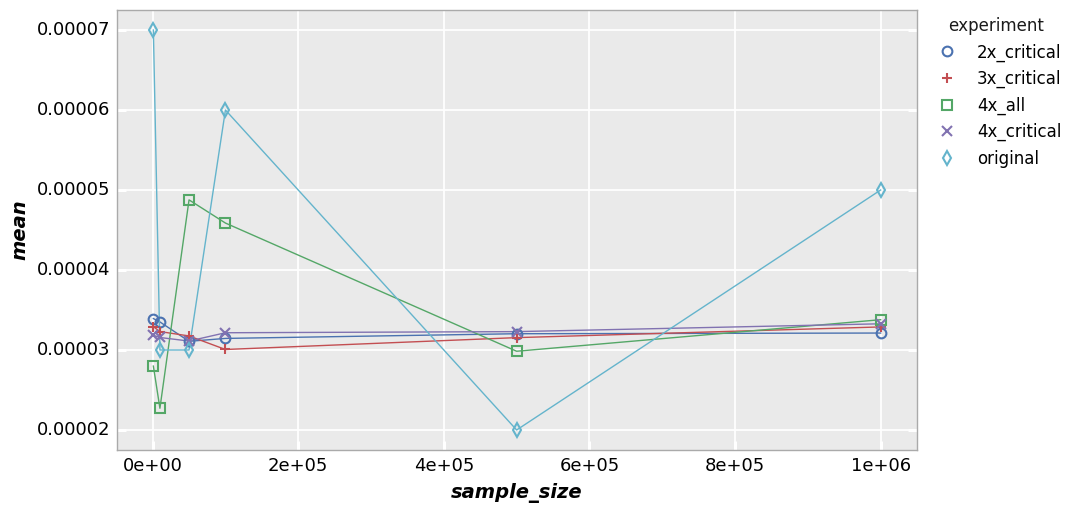

In [12]:
fcp.plot(df_importance, x='sample_size',y='mean',lines = True, markers = True,ax_size=(800,440), legend = 'experiment')

* You can see that number of simulations required to achieve aa a decent approximation is an order less than a simple Monte Carlo

## Probability Integral Transform
* Basically what it says is that, if you plug the random variables generated from a PDF in it's own CDF then the resulting r.vs are distributed according to $U[0,1]$.

Text(0.5, 0, '$x$')

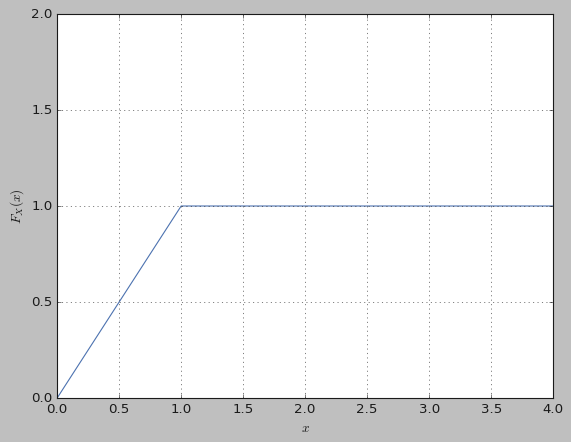

In [13]:
#plt.style.use('ggplot')
x = [0,1,2,3,4]
y = [0,1,1,1,1]
plt.plot(x,y)
plt.ylim([0,2])
plt.grid()
plt.ylabel('$F_{X}(x)$')
plt.xlabel('$x$')

* Above is the plot of a standard uniform distribution and it's equation is $F_{X}(x) = x$ and $P(x \leq c) = c$.
* $P(x \leq c) = \int_{0}^{c}dx= F_{X}(c) = c$

$\begin{align*} 
If \ Y = F_{X}(x) \ then \ Y \sim U[0,1] \tag{1}
\end{align*}$ 



$\begin{align*} 
F_{Y}(y) = P(Y\leq y) = P(F_{X}(x) \leq y) = P(X \leq F_{X}^{-1}(y)) \tag{2}
\end{align*}$ 

$\begin{align*} 
          = P(X \leq F_{X}^{-1}(F_{X}(x))) = P(X \leq x) = F_{X}(x) = y \tag{3}
\end{align*}$ 

Hence $F_{Y}(y) = y $ so, $Y \sim U[0,1]$






## Inverse Transform Sampling

* Claim: If $U \sim U(0,1)$ then $F^{-1}(U)$ has $F$ as its CDF.
* CDF of $F^{-1}(U)$ is 

$P(F^{-1}(U) \leq x) \tag{1}$

$=P(U \leq F(x)) \tag{2} $ If $x \sim U(0,1)$ then $P(x \leq c) = c$

$=F(x) \tag{3}$ 

## Variance of product of two independent RVs
* $Var(xy) = E(y^2)Var(x) + E(x)^2Var(y) + Var(x)Var(y)$

$Var(xy) = E[(xy-E[xy])^2]$

$xy-E[x]E[y] = E[x]E[y]\big(\frac{xy}{E(x)E(y)}-1\big)$

$            = E(x)E(y)\bigg( \big(\underset{p}{\underbrace{\frac{x-E(x)}{E(x)}}}+1\big)\big(\underset{q}{\underbrace{\frac{y-E(y)}{E(y)}}}+1\big)\bigg)$   

$(xy-E[x]E[y]) = E(x)E(y)((p+1)(q+1)-1)$

$(xy-E[x]E[y])^2 = E(x)^2E(y)^2((p+q+pq)^2$

$ = E(x)^2E(y)^2(p^2 + q^2 + 2p^2q + 2pq^2 + 2pq + p^2q^2)$

$ E(pq^2) = E(p^2q) = E(pq) = 0$

$ E(pq^2) = E\big[\big( \frac{x-E(x)}{E(x)} \big) \big( \frac{y-E(y)}{E(y)} \big)^2\big] = 0$

$ = E(x)^2E(y)^2E(p^2 + q^2 + p^2q^2)$

$ = E(x)^2E(y)^2\big[ E\big(\frac{x-E(x)}{E(x)}\big)^2 + E\big(\frac{y-E(y)}{E(y)}\big)^2 + 
E\big(\frac{x-E(x)}{E(x)}\big)^2\big(\frac{y-E(y)}{E(y)}\big)^2 \big]$